# Regression

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import shap
import numpy as np
import pandas as pd
import dalex as dx
import dice_ml
from dice_ml.utils import helpers
from dice_ml import Dice, data_interfaces, model_interfaces
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import xgboost as xgb
import warnings

# Disable user warnings
warnings.simplefilter("ignore", category=UserWarning)

class SklearnRegression:
    def __init__(self, test_size, random_state):
        self.test_size = test_size
        self.random_state = random_state

    def fetch_data(self):
        self.data = fetch_california_housing(as_frame=True)

    def preprocess_data(self):
        # Split the data into training and testing sets
        self.X = self.data.data
        self.y = self.data.target
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state)

    def val_shap_nytesy(self, explainer, shap_values, X_test_df, sample_index=0, is_list=False):
        """
        Visualize SHAP values for explaining model predictions.

        Args:
            explainer: SHAP explainer object.
            shap_values: SHAP values for the dataset.
            X_test_df (pandas.DataFrame): Test set features.
            sample_index (int): Index of the sample to be explained.
            is_list (bool): Whether shap_values is a list or not.
        """
        class_labels = ["< $50K", ">= $50K"]
        shap.summary_plot(shap_values, X_test_df, class_names=class_labels)

    def val_dalex_nytesy(self, clf, X_train_df, X_test_df, sample_index=0):
        """
        Visualize model explanations using the Dalex library.

        Args:
            clf: The trained regression model.
            X_train_df (pandas.DataFrame): Training set features.
            X_test_df (pandas.DataFrame): Test set features.
            sample_index (int): Index of the sample to be explained.
        """
        print("Dalex XAI Library")
        # Add protected and privileged features to your training data
        protected = self.X_train['AveOccup']  # Change 'AveOccup' to your protected feature
        privileged = self.X_train['HouseAge']  # Change 'HouseAge' to your privileged feature

        exp = dx.Explainer(clf, X_train_df, self.y_train, model_type='regression')
        exp.model_performance(model_type='regression').plot(geom='roc')
        predict_parts = exp.predict_parts(X_test_df.iloc[sample_index], type='break_down', label=X_test_df.index[sample_index])
        model_parts = exp.model_parts()
        model_parts.plot(max_vars=5)
        asp = dx.Aspect(exp)
        asp_pps = dx.Aspect(exp, depend_method='pps')
        asp.get_aspects(h=0.1)
        asp_pps.get_aspects(n=5)
        mt = asp.model_triplot(random_state=self.random_state)
        mt.plot()
        pt_def = asp.predict_triplot(X_test_df.iloc[sample_index], random_state=self.random_state)
        pt_def.plot()
        mai = asp.model_parts(h=0.1, label='aspects at threshold h=0.1')
        mai.plot()

    def val_dice_nytesy(self, clf, X_test_misclassified, Y_test_misclassified, Y_pred, misclassified):
        input_features = list(X_test_misclassified.columns)
        combined_df = X_test_misclassified.copy()
        combined_df['Y_pred_misclassified'] = Y_pred[misclassified]
        
        # Define the output feature (regression target)
        output_feature = 'Y_pred_misclassified'
        
        # Initialize ModelInterface for regression
        model_interface = dice_ml.Model(model=clf, backend='sklearn', model_type='regressor')
        
        # Initialize DataInterface for regression
        data_interface = dice_ml.Data(dataframe=combined_df, continuous_features=input_features, outcome_name=output_feature)
        
        # Create a Dice model for the given regressor
        d = dice_ml.Dice(data_interface, model_interface)
        
        for i in range(min(5, len(Y_test_misclassified)))[:1]:
            print(f"The actual value is {Y_test_misclassified.iloc[i]} and the predicted value is {Y_pred[misclassified][i]}")
            query_instance_df = pd.DataFrame(X_test_misclassified.iloc[i]).T
            # Calculate the actual target value for the sample (you can replace this with the actual target value)
            target_value = Y_test_misclassified.iloc[i]
            
            # Define a tolerance range
            tolerance = 0.1  # Adjust this value based on your use case

            # Specify the desired range for the target output
            desired_range = [target_value - tolerance, target_value + tolerance]
            
            # Call generate_counterfactuals with the desired_range parameter
            counterfactuals = d.generate_counterfactuals(
                query_instances=query_instance_df,
                total_CFs=1,
                desired_range=desired_range  # Set the desired_range parameter as a list
            )

            
            # Print the counterfactual
            counterfactual = counterfactuals.visualize_as_dataframe(show_only_changes=True)

    def train_and_evaluate_regressor(self, regressor, use_shap=False):
        """
        Train and evaluate a regression model.

        Args:
            regressor: The regressor class (e.g., RandomForestRegressor, LinearRegression).
            use_shap (bool): Whether to use SHAP for explanations (True/False).
        """
        X_train_df = self.X_train
        X_test_df = self.X_test
        is_list = True
        clf = regressor()

        if isinstance(clf, RandomForestRegressor):
            clf = regressor(n_estimators=50).fit(self.X_train, self.y_train)
            shap_explainer = shap.TreeExplainer(clf, feature_perturbation='interventional')
            shap_values = shap_explainer.shap_values(X_test_df, check_additivity=False)
            Y_pred = clf.predict(self.X_test)
        elif isinstance(clf, LinearRegression):
            clf = regressor().fit(self.X_train, self.y_train)
            shap_explainer = shap.Explainer(clf, X_train_df)
            shap_values = shap_explainer.shap_values(X_test_df)
            Y_pred = clf.predict(self.X_test)
        elif regressor == xgb.XGBRegressor:
            dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
            params = {
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse'
            }
            clf = xgb.train(params, dtrain)
    
            # Make predictions on the test set
            dtest = xgb.DMatrix(self.X_test)
            Y_pred = clf.predict(dtest)
    
            
            is_list = True
        elif regressor == lgb.LGBMRegressor:
            # Train the LightGBM regression model
            clf = lgb.LGBMRegressor()
            clf.fit(self.X_train, self.Y_train)
            Y_pred = clf.predict(self.X_test)
            is_list = True
        elif isinstance(clf, SVR):
            clf = regressor(kernel='linear').fit(self.X_train, self.y_train)
            data_subset = X_train_df
            X_test_df = X_test_df
            is_list = True
        else:
            clf = regressor().fit(self.X_train, self.y_train)
            clf.fit(self.X_train, self.Y_train)
            Y_pred = clf.predict(self.X_test)
            shap_explainer = shap.KernelExplainer(clf.predict, data_subset)
            
        
        # Evaluate the model
        mse = mean_squared_error(self.y_test, Y_pred)
        r2 = r2_score(self.y_test, Y_pred)

        print("XGBoost Regression - Mean Squared Error:", mse)
        print("XGBoost Regression - R-squared:", r2)
        misclassified = Y_pred != self.y_test
        X_test_misclassified = X_test_df[misclassified]
        Y_test_misclassified = self.y_test[misclassified]
        self.val_dalex_nytesy(clf, X_train_df, X_test_df)
        self.val_dice_nytesy(clf, X_test_misclassified, Y_test_misclassified, Y_pred, misclassified)
        if use_shap:
            if isinstance(clf, RandomForestRegressor):
                shap_values_misclassified = shap_explainer.shap_values(X_test_misclassified, check_additivity=False)
            else:
                shap_values_misclassified = shap_explainer.shap_values(X_test_misclassified)
            self.val_shap_nytesy(shap_explainer, shap_values, X_test_df, is_list)
protected_feature = "AveOccup"  # Example of a protected feature
privileged_feature = "AveBedrms"  # Example of a privileged feature
text_regressor = SklearnRegression(test_size=0.3, random_state=42)

text_regressor.fetch_data()
text_regressor.preprocess_data()

XGBoost Regression - Mean Squared Error: 0.5305677824766757
XGBoost Regression - R-squared: 0.595770232606166
Dalex XAI Library
Preparation of a new explainer is initiated

  -> data              : 14448 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14448 values
  -> model_class       : sklearn.linear_model._base.LinearRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x000001459FF092D0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -0.922, mean = 2.07, max = 7.23
  -> model type        : regression will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.91, mean = 1.26e-15, max = 4.18
  -> model_info        : package sklearn

A new explainer has been created!


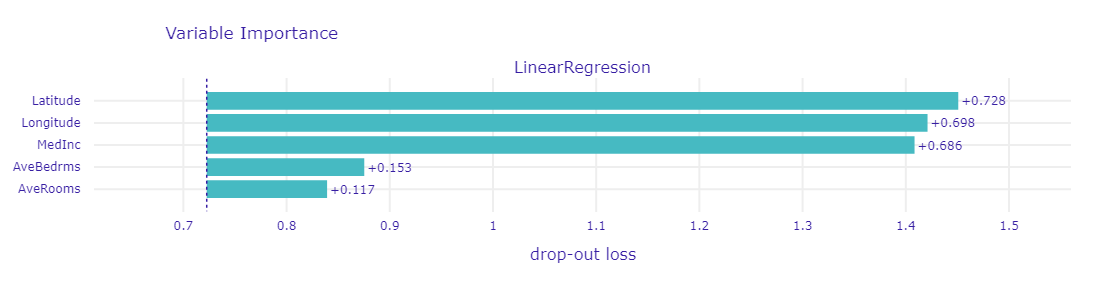

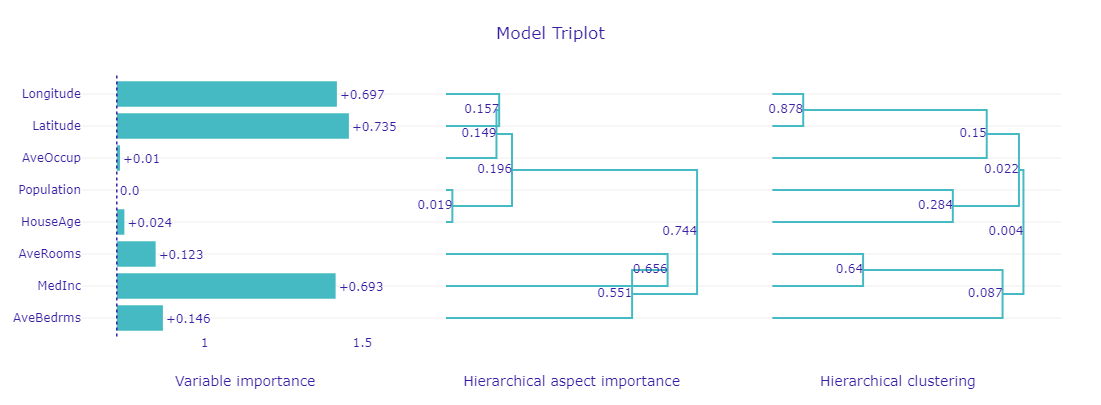

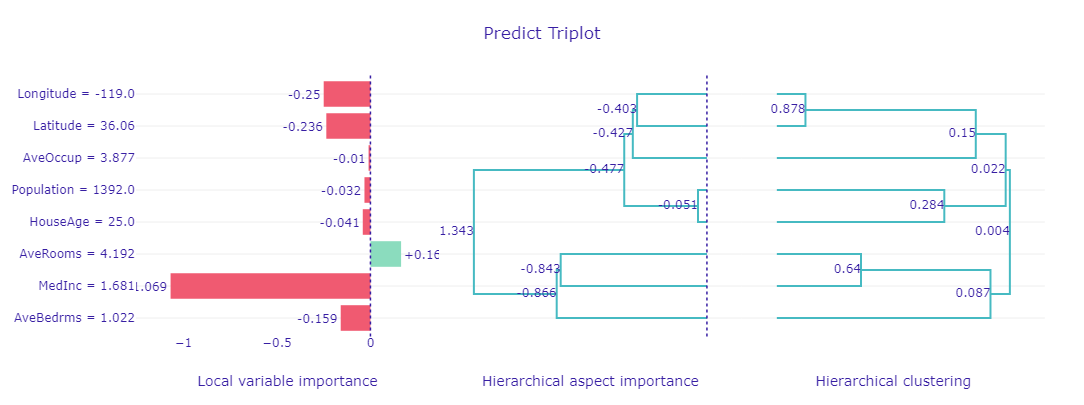

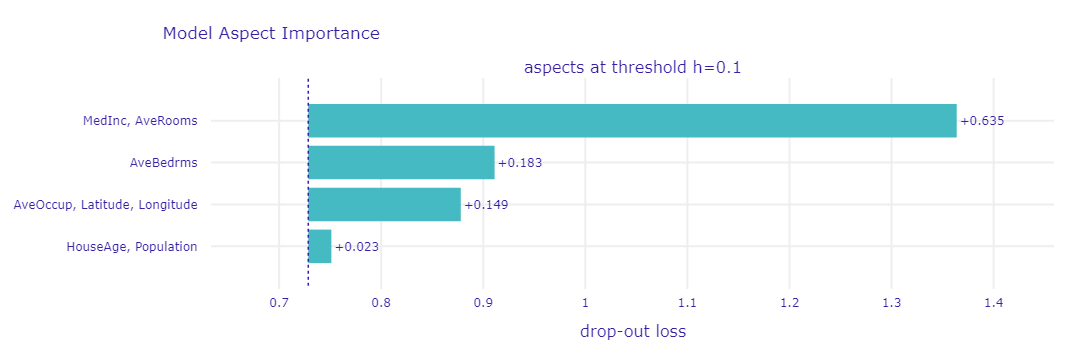

The actual value is 0.477 and the predicted value is 0.7260490726242494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]

Query instance (original outcome : 1.0)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Y_pred_misclassified
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,1.0



Diverse Counterfactual set (new outcome: [0.377, 0.577])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Y_pred_misclassified
0,-,-,-,-,-,81.9,-,-,0.46311095356941223


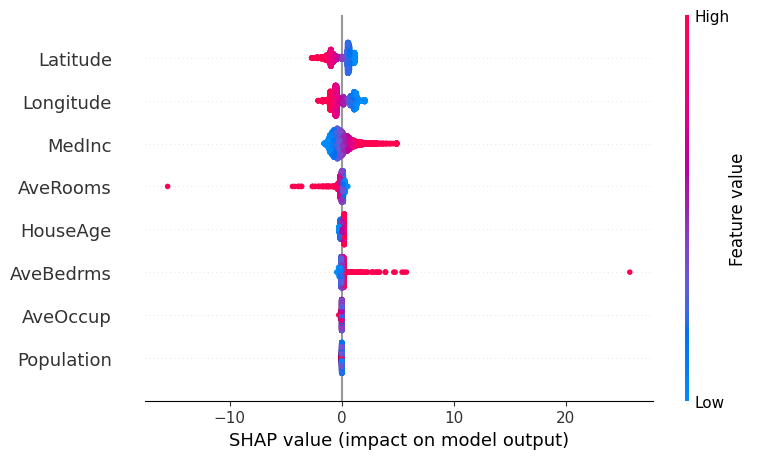

In [4]:
# Train and evaluate a regression model (e.g., RandomForestRegressor)
text_regressor.train_and_evaluate_regressor(LinearRegression, use_shap=True)

# Online Adaptive Random Forest

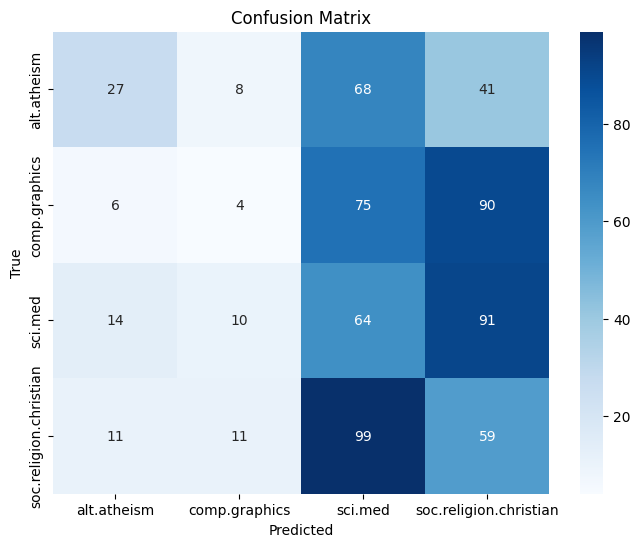

              precision    recall  f1-score   support

           0       0.47      0.19      0.27       144
           1       0.12      0.02      0.04       175
           2       0.21      0.36      0.26       179
           3       0.21      0.33      0.26       180

    accuracy                           0.23       678
   macro avg       0.25      0.22      0.21       678
weighted avg       0.24      0.23      0.20       678



In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from river.forest import ARFClassifier
from river import preprocessing
from river import metrics
from river.utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def convert_csr_to_dict(x):
    x_dict = {}
    for i in x.indices:
        x_dict[i] = x[0, i]
    return x_dict
    
class SklearnTrain:
    def __init__(self, test_size, categories, random_state):
        self.test_size = test_size
        self.categories = categories
        self.random_state = random_state
    
    def fetch_data(self):
        self.twenty_train = fetch_20newsgroups(subset='train', categories=self.categories, shuffle=True, random_state=self.random_state)
        self.X_data = self.twenty_train.data
        

    def train_and_evaluate_classifier(self):
        model = ARFClassifier()
        scaler = preprocessing.StandardScaler()
        metric = metrics.Accuracy()
        self.tf_transformer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5, ngram_range=(1,2)).fit(self.X_data)
        X_train, X_test, Y_train, Y_test = train_test_split(self.X_data, self.twenty_train.target, test_size=self.test_size, stratify=self.twenty_train.target)
        for x, y in zip(X_train, Y_train):
            x = self.tf_transformer.transform([x])  # Transform to a TF-IDF vector
            x = convert_csr_to_dict(x)  # Convert to CSR format
            model.learn_one(x, y)
        
        Y_pred = []
        for x in X_test:
            x = self.tf_transformer.transform([x])
            x = convert_csr_to_dict(x)  # Convert to CSR format
            x = scaler.transform_one(x)
            y_pred = model.predict_one(x)
            Y_pred.append(y_pred)
        
        # Generate and show the confusion matrix
        cm = confusion_matrix(Y_test, Y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.twenty_train.target_names, yticklabels=self.twenty_train.target_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
        print(classification_report(Y_test, Y_pred))

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
text_classifier = SklearnTrain(test_size=0.3, categories=categories, random_state=42)

text_classifier.fetch_data()
text_classifier.train_and_evaluate_classifier()
